# Large-Scale Image Processing On Your Laptop (and elsewhere)

### Valentina Staneva, Data Scientist, University of Washington

November 29, 2018

---
### Goals of this tutorial:

* get acquanted with the Python [Dask](http://dask.pydata.org/en/latest/) Library
* learn how to execute basic operations on large images which cannot fit in RAM
* learn about the concepts of lazy evaluation and task scheduling graphs
* learn how to work with [Dask Arrays](http://dask.pydata.org/en/latest/array.html)
* learn how to work with [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html)

---
### Motivation

What is this tutorial about? Researchers across domains get overloaded with image data which their traditional processing workflows are incapable to handle. Usually they are faced with two possible options: 
* move the processing to large machines/clusters
* modify their methods to access the image data only pieces at a time.


Researchers like to test out things on their laptops, and later move to clusters, without having to modify their code a lot.

[Dask](http://dask.pydata.org/en/latest/) is a Python Library which makes this possible: 
* can perform computations on objects which cannot fit into RAM
* has interface similar to `numpy` and `scipy`
* the same code used on your laptop can be run on a distributed cluster


The Dask library provides several useful objects
* [Dask Arrays](http://dask.pydata.org/en/latest/array.html) (for numpy-like operations) *
* [Dask DataFrames](http://dask.pydata.org/en/doc-test-build/dataframe.html) (for pandas-like operations)
* [Dask Bags](http://dask.pydata.org/en/latest/bag.html) (for unstructured-data-like operations, such as text)
* [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html) (for general functions and operations) *

We will be working with a [dataset of leaf images](https://archive.ics.uci.edu/ml/datasets/leaf) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/).The description is in
*'Evaluation of Features for Leaf Discrimination', Pedro F.B. Silva, Andre R.S. Marcal, Rubim M. Almeida da Silva (2013). Springer Lecture Notes in Computer Science, Vol. 7950, 197-204.*

In [7]:
import os
path = os.path.join('data','leaf','RGB')

In [8]:
# some preliminary imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Dask Arrays

Dask arrays are similar to numpy arrays, except that they are chunked into small pieces.

In [9]:
# check version of dask
# import dask
# dask.__version__
# !conda install --yes dask

In [10]:
import dask.array as da
from dask.array.image import imread

We can read a collection of images into a dask array.

In [11]:
leaf_images = imread(os.path.join(path,'*','*.JPG'))
leaf_images = leaf_images[:,::4,::4,:] # subsampling the images so that the processing is faster 
leaf_images

dask.array<getitem..., shape=(442, 240, 180, 3), dtype=uint8, chunksize=(1, 240, 180, 3)>

`leaf_images` is a `dask.array` is a multi-dimensional array which represents a chunked array.

Let's look at an image:

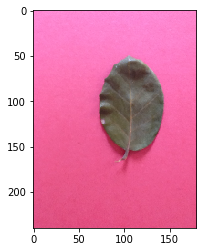

In [12]:
plt.imshow(leaf_images[0,:,:,:])

In [13]:
# saving the dimensions
T, m, n, d = leaf_images.shape

Each image is a separate chunk.

*The images are not loaded into RAM!!!!*

We can do computations on the dask array as long as individual chunks (and the computations on them) fit into RAM.

Let's  find the mean image:

In [14]:
%%time
leaf_images.mean(axis=0)

CPU times: user 11.3 ms, sys: 339 µs, total: 11.7 ms
Wall time: 11.2 ms


dask.array<mean_ag..., shape=(240, 180, 3), dtype=float64, chunksize=(240, 180, 3)>

The above statement creates another dask array, which is not loaded into RAM, i.e. it is not calculated yet. 
It waits for us tell dask explicitly when to do the calculation using the `compute` command. This is called [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation).

In [15]:
%%time
mean_leaf_image = leaf_images[:,:,:,0].mean(axis=0).compute()

CPU times: user 8.13 s, sys: 1.5 s, total: 9.63 s
Wall time: 2min 31s


In [16]:
mean_leaf_image.shape

(240, 180)

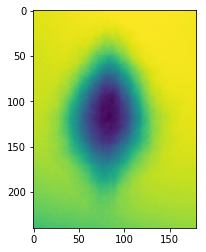

In [17]:
plt.imshow(mean_leaf_image)

***Important: only the final image is stored in RAM, which is smaller than the original collection!***

Note: if we pass a dask array to a function not supporting dask arrays, it often gets converted to an in-memory numpy array and evaluated. That is what happens when we pass the array to the imshow function.

A lot of other functions to perform on images using the [Dask API](http://dask.pydata.org/en/latest/array-api.html).

#### Visualizing graphs (optional)

You can visualize the individual steps of your computation as a graph. For example, this is the graph for computing a mean of an array consisting of 4 chunks:

<center>*Mean of a 2D Array*</center>
<img src="https://raw.githack.com/valentina-s/Dask_ImageXD_2018/master/dask_graph.png" width="300" height="200" >

![](dask_graph.png)

To show the graph of the current computation you need to install an additional package.

```
conda install graphviz

```
Then you can import `graphviz` in Python and for any dask array run

```
dask_array_name.visualize()
```

Try visualizing the graph for mean of all images. If the visualization does not look good in the notebook you can save it as a `.svg` file and look at the image via your browser:

```
dask_array_name.visualize('graph.svg')
```

In [ ]:
leaf_images[:,:,:,0].mean(axis=0).visualize('graph.svg',optimize_graph= True)

#### Monitoring Performance

In [ ]:
from dask.diagnostics import ProgressBar

In [ ]:
# Single machine progress bar
res = leaf_images.mean(axis=0)
with ProgressBar():
    out = res.compute()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# seems bokeh 0.13.0 is incompatible with visualize 
# (does not have an internal variable _state, so installing the previous version)
# !conda install --yes bokeh=0.12.9

In [ ]:
import bokeh
bokeh.__version__

In [ ]:
from bokeh.plotting import output_notebook
output_notebook()

In [ ]:
# cpu, ram performance
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
rprof = ResourceProfiler(dt=0.5)

res = leaf_images[:,:,:,0].mean(axis=0)
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    # wrapping the computation step with the Profiler
    out = res.compute()
    
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

#### Exercise: simple calculations

In [ ]:
# mean across the first channel for each image

In [ ]:
# mean for each RGB color for each image

#### Distributed Computing - beyond a single machine

[Dask Schedulers](http://dask.pydata.org/en/latest/scheduler-overview.html)

![](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

The default scheduler for dask arrays is threaded. It can be used only on a single machine. We can change to a distributed schedule by starting a client:

In [ ]:
# if you don't have dask distributed installed you can obtain it by uncommenting the line below:

#!conda install --yes tornado=4.5.3
!conda install --yes dask distributed


In [ ]:
# Distributed scheduler 

from dask.distributed import Client

client = Client()  # use dask.distributed by default
print(client)

From now on any `compute` command will use the distributed scheduler.

In [ ]:
mean_leaf_image = leaf_images.mean(axis = 0).compute()

In [ ]:
# Distributed Progress Bar
from dask.distributed import progress
out = leaf_images.mean(axis = 0).compute()
progress(out)
# this requires the ipython widgets enabled, do it by:
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

**Blocking and Persisting**

The compute operation is blocking, i.e we have to wait for it to finish to compute the next step. When the task graph is large and it involves some expensive operations such as reading from disk multiple times, this becomes inefficient. In that case it is better to keep the data object in distributed RAM and this can be achieved using the `persist` function. Persist starts the computation immediately (i.e. it is not lazy). 

In [ ]:
leaf_images_persisted = client.persist(leaf_images)  # start computation in the background
leaf_images_persisted.dask     # watch progress

In [ ]:
# shut down the client
client.shutdown()

In [ ]:
# we can return to the threaded scheduler at any time
import dask
dask.set_options(scheduler='threads')

Key Points:

* dask arrays are not loaded into memory until you start doing computations on them
* computations on dask arrays are not executed until you ask for them via `.compute`()
* passing a `dask.array` to a `numpy` or `matplotlib` function might work but the computation will be done in memory
* sometimes it is helpful to load data into memory: for that use persist with the distributed scheduler

---
### Perform Principal Component Analysis on a Collection of Images

PCA can be perform by the following steps:
* center the images
* reshape the data into a matrix # features x # observations format
* perform SVD on the data matrix D = USV^T
* flip the signs to make the output deterministic
* reshape the columsn of U into an image format -> these are the principal directions

In [ ]:
# center the images
leaf_images_centered = leaf_images - leaf_images.mean(axis = 0)

In [18]:
# create a data matrix - # observations x # features
data = leaf_images[:,:,:,0].reshape((-1,m*n))

print(data.shape)
data

(442, 43200)


dask.array<reshape..., shape=(442, 43200), dtype=uint8, chunksize=(1, 43200)>

The singular value decomposition uses QR decomposition under the hood, in particular dask uses the Tall-And-Skinny QR algorithm.

In [19]:
help(da.linalg.tsqr)

Help on function tsqr in module dask.array.linalg:

tsqr(data, name=None, compute_svd=False)
    Direct Tall-and-Skinny QR algorithm
    
    As presented in:
    
        A. Benson, D. Gleich, and J. Demmel.
        Direct QR factorizations for tall-and-skinny matrices in
        MapReduce architectures.
        IEEE International Conference on Big Data, 2013.
        http://arxiv.org/abs/1301.1071
    
    This algorithm is used to compute both the QR decomposition and the
    Singular Value Decomposition.  It requires that the input array have a
    single column of blocks, each of which fit in memory.
    
    If blocks are of size ``(n, k)`` then this algorithm has memory use that
    scales as ``n**2 * k * nthreads``.
    
    Parameters
    ----------
    
    data: Array
    compute_svd: bool
        Whether to compute the SVD rather than the QR decomposition
    
    See Also
    --------
    
    dask.array.linalg.qr - Powered by this algorithm
    dask.array.linalg.svd - Pow

Our data matrix is short-and-fat, so we will apply the svd to the transpose.

In [20]:
data.shape

(442, 43200)

* single column of blocks

|   |
|------|
|   |
|   |
|   |
|   | 
|   |
|   |
|   |

In [21]:
data = data.rechunk((T,260))
data.T

dask.array<transpo..., shape=(43200, 442), dtype=uint8, chunksize=(260, 442)>

In [22]:
u, s, vt = da.linalg.svd(data.T)

We have learned that to obtain the values of a dask array we need to run 

```
    u.compute()
```

However, if we do it for each u,s,vt it will be inefficient since we will have to compute the svd 3 times. When there are multiple outputs we can use dask's `compute` function to do the computation simultenously.

In [23]:
from dask import compute

In [ ]:
%%time
u, s, vt = compute(u[:,:10],s[:10],vt[:,:10])

In [ ]:
# run with the profiler
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    u, s, vt = da.linalg.svd(data.T)
    u, s, vt = compute(u[:,:10],s[:10],vt[:,:10])

visualize([prof, rprof, cprof])

**Exercise: **
    
Compare with the standard scipy linear algebra library. Think about when it is good enough.

Finally, we should visualize the results.

Recall that principal components are unique up to a sign change. So in order that we all obtain the same result we can flip the sings based on vt using the following `svd_flip` function.

In [ ]:
u.shape

In [ ]:
# flip signs based on vt
from sklearn.utils.extmath import svd_flip
u, vt = svd_flip(u,vt.T)

In [ ]:
# convert the components to back to images
u = u.reshape(m,n,10)

In [ ]:
# plot the results
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((u[:,:,i]-u.min())/(u.max() - u.min()))
    plt.title('Mode '+str(i+1))

Key Points:
* some dask functions are strict about the form of the chunks
* not all familiar methods are implemented within dask, but you can still run them using the existing base functions
* on a regular laptop complex dask algorithms might not be faster than numpy equivalents but they do not overload the memory

----
**PCA through [`dask-ml`](http://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.decomposition.PCA.html)**

Some of the new functionality of dask for data analysis is implemented within the separate [`dask-ml`](http://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.decomposition.PCA.html) package. It is under active development so expect changes and new stuff!

If you have used `scikit-learn` it will look very similar.

In [ ]:
# if you do not have dask-ml installed, you can do it by uncommenting the command below
!conda install -c conda-forge --yes dask-ml

In [1]:
from dask_ml.decomposition import PCA 

In [2]:
pca = PCA(n_components=10)

In [24]:
data

dask.array<rechunk..., shape=(442, 43200), dtype=uint8, chunksize=(442, 260)>

In [25]:
%%time
pca.fit(data)

CPU times: user 9.67 s, sys: 2.94 s, total: 12.6 s
Wall time: 2min 31s


PCA(copy=True, iterated_power=0, n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
print(pca.components_.shape)
u = pca.components_.reshape(-1,m,n)

(10, 43200)


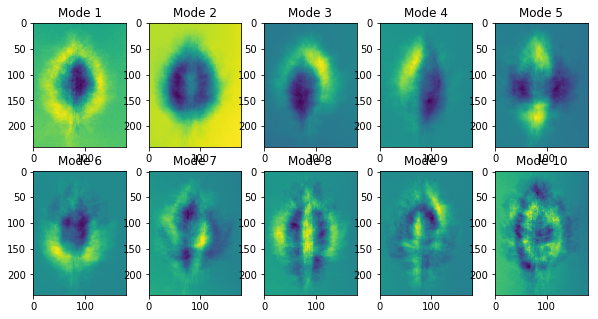

In [27]:
# plot the results
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((u[i,:,:]-u.min())/(u.max() - u.min()))
    plt.title('Mode '+str(i+1))

#### Extra Exercises

**Exercise: chunking performance**

Try using different chunk sizes and compare the speed of the svd computation.

**Exercise: faster svd**

Theleaf dataset can be loaded into RAM on most laptops so you can compare the speed with running the [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) using the `scikit-learn` package. It can actually faster than the dask svd. The reason is that when the data is too big the existing packages by default do not compute the full `svd` , instead they implement a randomized svd algorithm. Compare the speed when passing the parameter `svd_solver = full`. 

Dask has the corresponding implementation in `da.linalg.svd_compressed`. 

In [ ]:
help(da.linalg.svd_compressed)

Compare the speed, compare the results. Can you find the parameters to obtain similar performance?

----
### Perform Complex Operations on a Collection of Images.

We consider the following scenario: 

we have a big pile of images and we need to perform the same pre-processing step to each image and in the end store the result in one array for further processing.

Clearly we can achieve this by writing a `for-loop` which processes each image and stores the result. 

To accomplish this in a distributed manner we can use `dask`'s [delayed](http://dask.pydata.org/en/latest/delayed.html) functionality. It allows to parallelize our own Python functions.

In [28]:
from dask import delayed

Let's say we want to convert each image to gray scale. We can use the `rgb2gray` function.



In [29]:
from skimage.color import rgb2gray

We can convert a regular Python function to a dask delayed function:

In [30]:
rgb2gray_dask = delayed(rgb2gray)

In [31]:
# create delayed evaluations
lazy_values = [rgb2gray_dask(im) for im in leaf_images]

In [32]:
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n), dtype=leaf_images.dtype) for lazy_value in lazy_values]

We can see that the type of this final result is a list and each entry is a `dask array`:

In [33]:
print(type(arrays))
print(type(arrays[0]))

<class 'list'>
<class 'dask.array.core.Array'>


We can convert them to a dask array:

In [34]:
stack = da.stack(arrays, axis=0) 
stack

dask.array<stack-c..., shape=(442, 240, 180), dtype=uint8, chunksize=(1, 240, 180)>

Text(0.5,1,'Grayscale Image')

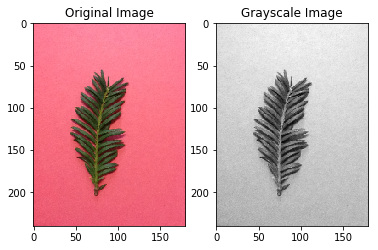

In [35]:
plt.subplot(1,2,1)
plt.imshow(leaf_images[100,:,:,:])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(stack[100,:,:],cmap = 'gray')
plt.title('Grayscale Image')

Note: there are alternative approaches to applying a function to a collection of objects in a distributed manner, `dask delayed` is most useful when we want to store the results in a distributed array on which to perform further operations.

Key Points:
* any Python function can be converted to a dask function using `delayed`
* it is most useful to use `dask delayed` when the output can be stored in a dask object
* the power of `dask delayed` is more noticeable on many-core machines or clusters

#### Extra Exercises

**Exercise: segmenting images**

It is possible to segment the leaves using a simple thresholding method. Let's try out the `threshold_otsu` function on the first channel.

In [36]:
from skimage.filters import threshold_otsu
im = leaf_images[0,:,:,0].compute()
res = threshold_otsu(im)
print(res)

174


The `threshold_otsu` returns a single value, but we want the thresholded image. We can create our own version of the function which returns a binary image, and then repeat the previous procedure.

In [37]:
def threshold_otsu_binary(im):
    thresh = threshold_otsu(im)
    return((im>thresh).astype('float64'))    

In [38]:
# delaying the function
threshold_otsu_dask = delayed(threshold_otsu_binary)

# lazy evaluations
lazy_values = [threshold_otsu_dask(im) for im in leaf_images[:,:,:,0]]

# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(m,n), dtype='float64') for lazy_value in lazy_values]

# creating the dask array
stack = da.stack(arrays, axis=0) 
stack

dask.array<stack-e..., shape=(442, 240, 180), dtype=float64, chunksize=(1, 240, 180)>

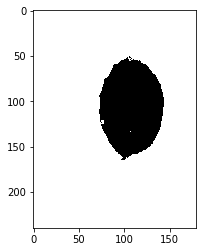

In [39]:
plt.imshow(stack[0,:,:],cmap = 'gray')

**Exercise: explore the dataset**

* approximate the area of each leaf.

* calculate the length of the boundary of each leaf.

* can you classify the leaves based on area and length?


**Exercise: delayed performance**

Compare the speed of this approach to applying the algorithm through a for loop. 

Compare the performance using different schedulers. 

Compare with some of the other Python parallelization packages.

----
### Further Resources
* [Scipy 2016 Parallel Python Tutorial](https://www.youtube.com/watch?v=5Md_sSsN51k&list=PLYx7XA2nY5Gf37zYZMw6OqGFRPjB1jCy6&index=13) - comparison of different approaches for parallelization in Python
* [Distributed Images Blog](http://matthewrocklin.com/blog/work/2017/01/17/dask-images) - an example of processing a large image dataset on an Amazon EC2 cluster 
* Deploying on the cloud : [Dask with Kubernetes and Helm](http://dask.pydata.org/en/latest/setup/kubernetes-helm.html)